In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV






# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [87]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
1234,10/01/2021 22:31:57,26.0,Male,Saint-Petersburg,Project Manager,5,NaN,Middle,Python,"Python, .NET, Azure",20000.0,2000,24,Full-time employee,Unlimited contract,Russian,1000+,Product
820,27/11/2020 11:04:39,34.0,Male,Berlin,Lead Software Developer,13,2,Lead,C#,".NET, Kubernetes, Docker",65000.0,0,30,Full-time employee,Unlimited contract,English,51-100,Product
836,27/11/2020 12:56:27,44.0,Male,Frankfurt,Software Engineer,10,10,Senior,SAP ABAP,SAP / ABAP,75000.0,80000,30,Full-time employee,Unlimited contract,Russian,101-1000,Product
302,24/11/2020 15:59:02,30.0,Male,Berlin,Backend Developer,7,2,Senior,Ruby,"Javascript / Typescript, SQL, Go, AWS, Docker",72000.0,0,25,Full-time employee,Unlimited contract,English,11-50,Product
1097,05/12/2020 22:37:41,36.0,Male,Berlin,Staff Engineer,15,4,Lead,Go,"PHP, AWS, Kubernetes, Docker",85000.0,3000,28,Full-time employee,Unlimited contract,English,1000+,Product
597,25/11/2020 14:00:28,38.0,Male,Berlin,Data Scientist,15,3,Senior,Python,"Python, SQL, AWS",56000.0,59000,21,Full-time employee,Unlimited contract,English,11-50,Product
1164,14/12/2020 16:39:33,29.0,Male,Berlin,Software Engineer,6,1,Senior,Python,"Javascript / Typescript, Google Cloud, Docker",70000.0,10000,27,Full-time employee,Unlimited contract,English,1000+,Product
1202,25/12/2020 17:03:05,27.0,Male,Krakow,QA Engineer,5,1,Senior,java,Python,35000.0,0,28,Full-time employee,Temporary contract,English,101-1000,Product
907,29/11/2020 15:23:30,33.0,Male,Berlin,Software Engineer,7,1,Middle,Ruby,"Javascript / Typescript, Ruby, AWS, Docker",54000.0,0,28,Full-time employee,Temporary contract,English,51-100,Startup
167,24/11/2020 12:23:06,28.0,Male,Moldova,Backend Developer,4,0,Middle,Java,"Kotlin, Java / Scala",28000.0,NaN,NaN,NaN,NaN,English,51-100,Startup


In [89]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [90]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [91]:
# Remove the rows with missing values
df.dropna(inplace=True)

# Remove the duplicates
df.drop_duplicates(inplace=True)

# Replace the invalid values with a meaningful representation
df.replace(-999, 0, inplace=True)

# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df['target'] = df['target'].fillna(df['target'].median())
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()


,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
5,32.0,Male,Berlin,DevOps,5,1,Senior,"AWS, GCP, Python,K8s","Python, AWS, Google Cloud, Kubernetes, Docker",30,Full-time employee,Unlimited contract,English,11-50,Startup,81000.0
19,34.0,Male,Berlin,Mobile Developer,11,5,Lead,kotlin,"Kotlin, Javascript / Typescript, AWS, Google C...",28,Full-time employee,Unlimited contract,English,101-1000,Product,160000.0
25,38.0,Male,Berlin,Team Lead,18,4,Lead,iOS,"Swift, AWS",28,Full-time employee,Unlimited contract,English,101-1000,Product,84000.0


<AxesSubplot:xlabel='target', ylabel='Count'>

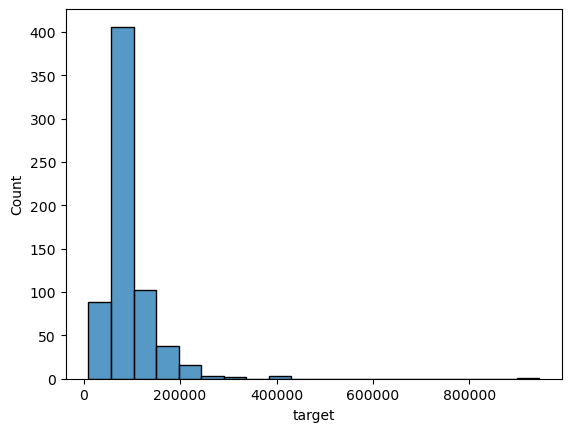

In [92]:
sns.histplot(df['target'], bins=20)

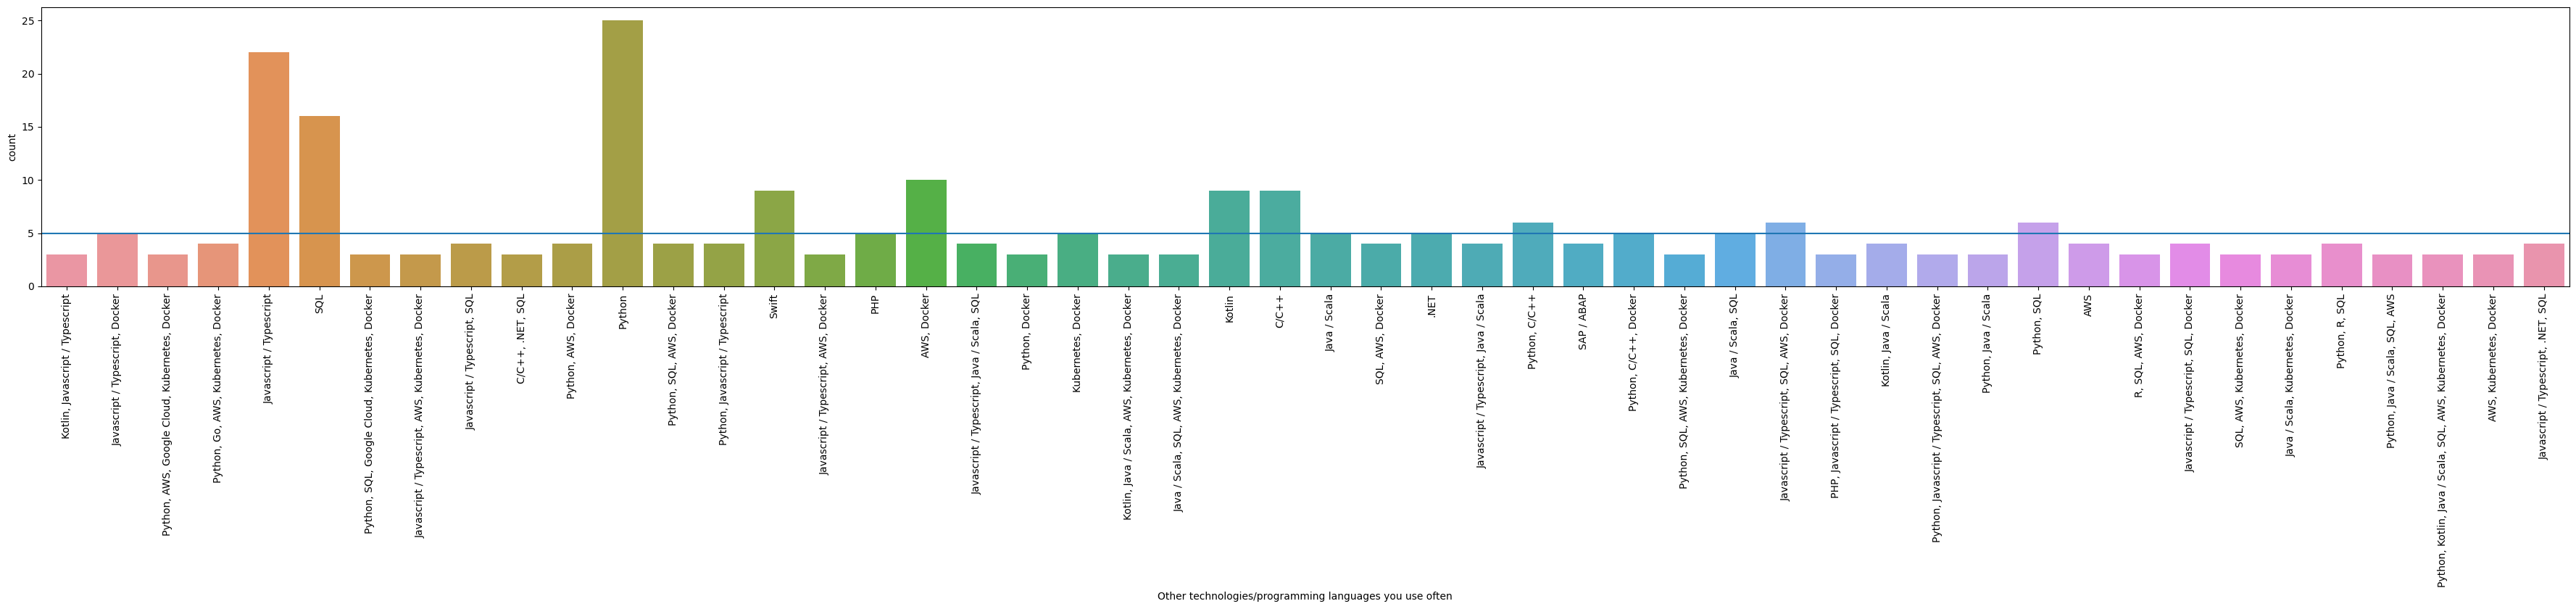

In [93]:
# Construct a temporary dataset with things that have > 2 records
# remove outliers
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(5)
ax.tick_params(axis='x', rotation=90)

In [94]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [95]:
df['City'].value_counts().head(10)

Berlin        342
Munich        144
Frankfurt      23
Hamburg        19
Cologne        12
Stuttgart       8
Amsterdam       5
Heidelberg      4
Prague          4
Karlsruhe       3
Name: City, dtype: int64

City

In [96]:
#This code is replacing low frequency values in the "City" column with the value "Other".
df["City"] = replace_low_freq(df, "City", 10, "Other")
df["City"].value_counts()

Berlin       342
Munich       144
Other        120
Frankfurt     23
Hamburg       19
Cologne       12
Name: City, dtype: int64

Position

In [97]:
df['Position '].value_counts().head(20)

Software Engineer      220
Backend Developer       87
Data Scientist          81
Frontend Developer      43
DevOps                  31
Mobile Developer        30
QA Engineer             29
ML Engineer             25
Data Engineer           15
Engineering Manager      6
Data Analyst             5
Product Manager          3
CTO                      3
SRE                      3
Consultant               3
Software Architect       2
Business Analyst         2
Product Analyst          2
Data Analyst             2
Fullstack Developer      2
Name: Position , dtype: int64

In [98]:
#The code replaces low frequency values in the "Position" column with the label "Other". 
df['Position '] = replace_low_freq(df, 'Position ', threshold=10, replacement='Other')
df['Position '].value_counts()

Software Engineer     220
Other                  99
Backend Developer      87
Data Scientist         81
Frontend Developer     43
DevOps                 31
Mobile Developer       30
QA Engineer            29
ML Engineer            25
Data Engineer          15
Name: Position , dtype: int64

Programming Languages

In [99]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts()

Other         259
Python        105
Java          102
C++            27
PHP            25
C#             18
python         17
Go             15
Swift          15
Python         15
Scala          15
JavaScript     13
Javascript     12
.NET           11
Kotlin         11
Name: Your main technology / programming language, dtype: int64

In [100]:
#Fix a couple of spelling mistakes and recount them again
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)
df["Your main technology / programming language"].value_counts()

Other         259
Python        120
Java          102
C++            27
PHP            25
JavaScript     25
C#             18
python         17
Go             15
Swift          15
Scala          15
.NET           11
Kotlin         11
Name: Your main technology / programming language, dtype: int64

Experience

In [101]:
df['Total years of experience'].value_counts(ascending=True).head(10)

3.5                                 1
1,5                                 1
1.5                                 1
31                                  1
15, thereof 8 as CTO                1
2,5                                 1
1 (as QA Engineer) / 11 in total    1
27                                  1
less than year                      1
26                                  1
Name: Total years of experience, dtype: int64

In [102]:
df['Total years of experience'].replace(",",".",regex=True, inplace=True)
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], errors="coerce")
df['Total years of experience'].value_counts(ascending=True).head(10)

3.5     1
31.0    1
27.0    1
26.0    1
23.0    1
28.0    1
29.0    1
5.5     1
22.0    2
4.5     2
Name: Total years of experience, dtype: int64

In [103]:
df['Years of experience in Germany'].value_counts(ascending=True).head(10)

less than year    1
0.2               1
-                 1
3 (in Poland)     1
4.5               1
3 months          1
18                1
30                1
16                1
1,5               1
Name: Years of experience in Germany, dtype: int64

In [104]:
df['Years of experience in Germany'].replace(",",".",regex=True, inplace=True)
df['Years of experience in Germany'] = pd.to_numeric(df['Total years of experience'], errors="coerce")
df['Years of experience in Germany'].value_counts(ascending=True).head(10)

3.5     1
31.0    1
27.0    1
26.0    1
23.0    1
28.0    1
29.0    1
5.5     1
22.0    2
4.5     2
Name: Years of experience in Germany, dtype: int64

Seniority Level

In [105]:
df['Seniority level'].value_counts().head(10)

Senior                       295
Middle                       193
Lead                          98
Junior                        39
Head                          24
Principal                      2
CTO                            1
Director                       1
C-level executive manager      1
intern                         1
Name: Seniority level, dtype: int64

In [106]:
df['Seniority level'] = replace_low_freq(df, 'Seniority level', 5, 'Other')
df['Seniority level'].value_counts().head(10)

Senior    295
Middle    193
Lead       98
Junior     39
Head       24
Other      11
Name: Seniority level, dtype: int64

Vacation Days

In [107]:
df['Number of vacation days'].value_counts(ascending=True).head(10)

16           1
5            1
1            1
37.5         1
Unlimited    1
15           1
unlimited    1
12           1
3            1
39           1
Name: Number of vacation days, dtype: int64

In [108]:
df['Number of vacation days'] = pd.to_numeric(df['Number of vacation days'], errors="coerce")

In [109]:
df['Number of vacation days'].value_counts(ascending=True).head(10)

16.0    1
5.0     1
1.0     1
37.5    1
15.0    1
12.0    1
3.0     1
39.0    1
23.0    1
10.0    1
Name: Number of vacation days, dtype: int64

Employment Status

In [110]:
df['Employment status'].value_counts().head(10)

Full-time employee                                                     641
Self-employed (freelancer)                                              12
Part-time employee                                                       3
working student                                                          1
Working Student                                                          1
full-time, but 32 hours per week (it was my request, I'm a student)      1
Werkstudent                                                              1
Name: Employment status, dtype: int64

In [111]:
df['Employment status'] = replace_low_freq(df, 'Employment status', threshold=5, replacement=np.nan)

Gender

In [112]:
df['Gender'] = df['Gender'].fillna('Other')
df['Gender'] = df['Gender'].replace('Diverse', 'Other')

Company Type

In [113]:
df['Company type'].value_counts().head(10)

Product                415
Startup                122
Consulting / Agency     80
Bank                     2
Utilities                2
Finance                  2
Research                 2
Corporation              2
E-commerce               2
Media                    2
Name: Company type, dtype: int64

In [114]:
df['Company type'] = replace_low_freq(df, 'Company type', threshold=5, replacement='Other')

Contract Duration

In [115]:
df['Сontract duration'].value_counts()

Unlimited contract    630
Temporary contract     29
0                       1
Name: Сontract duration, dtype: int64

Language

In [116]:
df['Main language at work'].value_counts().head()

English    543
German     101
Russian      6
Italian      2
Spanish      2
Name: Main language at work, dtype: int64

In [117]:
df['Main language at work'] = replace_low_freq(df, 'Main language at work', threshold=5, replacement='Other')

In [118]:
numeric_features = ["Age", "Number of vacation days", "Total years of experience", "Years of experience in Germany"]
categorical_features = ["Company type", "Company size", "Main language at work", "Сontract duration", "Employment status", "Your main technology / programming language", "Seniority level", "Position ", "City", "Gender"]

In [119]:
for col in numeric_features:
    df[col]=df[col].astype(float)
for col in categorical_features:
    df[col]=df[col].astype("category")

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   Age                                                     660 non-null    float64 
 1   Gender                                                  660 non-null    category
 2   City                                                    660 non-null    category
 3   Position                                                660 non-null    category
 4   Total years of experience                               657 non-null    float64 
 5   Years of experience in Germany                          657 non-null    float64 
 6   Seniority level                                         660 non-null    category
 7   Your main technology / programming language             660 non-null    category
 8   Other technologies/programmin

### Prep for Modelling

In [121]:
# Define the pipelines for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

# Use ColumnTransformer to apply the pipelines to the appropriate features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

In [122]:
# Split the data into training and testing sets
# Use the 'target' column as the target variable
y = df["target"]
# Drop the target variable from the DataFrame
X = df.drop("target", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [123]:
# Build the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_jobs=-1, n_estimators=500))
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the training and testing data
train_r2 = pipeline.score(X_train, y_train)
train_rmse = mean_squared_error(y_train, pipeline.predict(X_train), squared=False)
test_r2 = pipeline.score(X_test, y_test)
test_rmse = mean_squared_error(y_test, pipeline.predict(X_test), squared=False)

print("Depth:", pipeline.named_steps['model'])
print("Train R2:", train_r2)
print("Train RMSE:", train_rmse)
print("Test R2:", test_r2)
print("Test RMSE:", test_rmse)

Depth: RandomForestRegressor(n_estimators=500, n_jobs=-1)
Train R2: 0.8712008618391541
Train RMSE: 17754.569833442605
Test R2: 0.06409990875565197
Test RMSE: 76152.32354865721


Add Feature selection

In [124]:
# Use RFECV for feature selection
rfecv = RFECV(
    estimator=RandomForestRegressor(n_jobs=-1, n_estimators=500),
    step=1,
    cv=5,
    scoring="r2",
    min_features_to_select=3
)

# Build the pipeline
pipeline2 = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selector", rfecv),
    ("model", RandomForestRegressor(n_jobs=-1, n_estimators=500))
])

# Fit the pipeline to the training data
pipeline2.fit(X_train, y_train)

# Evaluate the pipeline on the training and testing data
train_r2 = pipeline2.score(X_train, y_train)
train_rmse = mean_squared_error(y_train, pipeline2.predict(X_train), squared=False)
test_r2 = pipeline2.score(X_test, y_test)
test_rmse = mean_squared_error(y_test, pipeline2.predict(X_test), squared=False)

print("Depth:", pipeline2.named_steps['model'])
print("Number of selected features:", rfecv.n_features_)
print("Train R2:", train_r2)
print("Train RMSE:", train_rmse)
print("Test R2:", test_r2)
print("Test RMSE:", test_rmse)

Depth: RandomForestRegressor(n_estimators=500, n_jobs=-1)
Number of selected features: 52
Train R2: 0.8719074568589126
Train RMSE: 17705.80186768581
Test R2: 0.06752699225266767
Test RMSE: 76012.7682013676


Add Grid search

In [125]:
params = {'model__max_depth':[5,6,7,8,9,10], 
          'model__n_estimators':[75,100,125,150,200,300,400],
          'model__ccp_alpha':[.0001, .0005, .001, .005, .01, .05, .1, .5, 1]}

clf = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
print(clf.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'Number of vacation days',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEnc

In [126]:
model = RandomForestRegressor(ccp_alpha=0.0001, max_depth=5,
                                       n_estimators=75, n_jobs=-1)

In [127]:
rfecv2 = RFECV(
    estimator= Ridge(max_iter=100000),
    step=1,
    cv=5,
    scoring='r2',
    min_features_to_select=3,
)

pipeline_steps3 = [('pre', preprocessor),
                ('feature selection', rfecv2),
                ('model', model) ]

pipe3 = Pipeline(pipeline_steps3)
pipe3.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'Number of vacation days',
                                                   'Total years of experience',
                                                   'Years of experience in '
                                                   'Germany']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Company type',
                                                   'Company size',
                                                   'Main language at work',
                                                   'Сontract duration',
                                                   'Employment status',
                                                   'Your main technology / '
                                                   'programming language',
                                                   'Seniority level',
                                                   'Position ', 'City',
                                                   'Gender'])])),
                ('feature selection',
                 RFECV(cv=5, estimator=Ridge(max_iter=100000),
                       min_features_to_select=3, scoring='r2')),
                ('model',
                 RandomForestRegressor(ccp_alpha=0.0001, max_depth=5,
                                       n_estimators=75, n_jobs=-1))])

In [128]:
print("Depth:", pipe3.named_steps['model'])
print("Features:", rfecv2.n_features_, rfecv2.n_features_in_)
print("Train R2:", pipe3.score(X_train, y_train))
print("Train RMSE:", mean_squared_error(y_train, pipe3.predict(X_train), squared=False))
print("Test R2:", pipe3.score(X_test, y_test))
print("Test RMSE:", mean_squared_error(y_test, pipe3.predict(X_test), squared=False))

Depth: RandomForestRegressor(ccp_alpha=0.0001, max_depth=5, n_estimators=75, n_jobs=-1)
Features: 14 60
Train R2: 0.2632568066471961
Train RMSE: 42463.1044555596
Test R2: 0.0432473665964388
Test RMSE: 76996.01480289252


## Answers and Explainations

### Clean the Data
<i> Check for outliers
<i> Standardize or normalize the data
<i> Remove or impute missing values
<i> replacing low frequency values in the  columns with the value "Other"

### Prep for Modelling
<i> A pipeline is defined for numerical and categorical features separately.
<i> A ColumnTransformer is used to apply the pipelines to appropriate features in the DataFrame.
<i> The data is split into training and testing sets and the 'target' column is used as the target variable.
<i> A pipeline is built using the preprocessor and a RandomForestRegressor model with n_jobs=-1 and n_estimators=500.
<i> The pipeline is fit to the training data and evaluated using R2 and RMSE scores for both training and testing data.

### Feature selection
<i> RFECV (Recursive Feature Elimination with Cross-Validation) is used for feature selection.
<i> A new pipeline is built using the same preprocessor as the previous pipeline and adds a feature selector and a model.
<i> The pipeline is fitted to the training data.
<i> The pipeline is evaluated on the training and testing data using R2 score and root mean squared error (RMSE).

### Grid search
<i> Use RFECV for feature selection
<i> Create a pipeline with pre-processing, feature selection, and random forest regression
<i> Fit the pipeline to the training data and evaluate on both the training and testing data
<i> Define a dictionary of hyperparameters for the random forest regression model

###  Results
The initial model's performance suggests that it is overfitting to the training data. A high R2 score of 0.871 on the training data indicates that the model can explain a large portion of the variance in the target variable, which is good. However, the low R2 score of 0.064 on the test data suggests that the model is failing to generalize to new, unseen data. This discrepancy can be attributed to overfitting, where the model is too complex and captures noise in the training data, rather than learning the underlying patterns that generalize well to new data.

To improve the model's generalization ability, we can try feature selection and hyperparameter tuning. Feature selection involves selecting a subset of relevant features from the dataset, which can help to reduce the complexity of the model and prevent overfitting. Hyperparameter tuning involves searching for the best set of hyperparameters, such as the maximum depth of a decision tree or the number of estimators in a random forest, which can improve the model's performance.

By implementing feature selection and hyperparameter tuning, we can expect to see improved performance on the test data, as the model becomes more generalizable and better able to capture the underlying patterns in the data.


### Feature Selection Activities:
The first model did not use any feature selection techniques, meaning that all available features were used for model training.
The second model used Recursive Feature Elimination with Cross-Validation (RFECV) to perform feature selection. RFECV works by repeatedly training a model with a decreasing number of features and selecting the set of features that produces the best cross-validation score. The selected features are then used for model training.
The third model used RFECV with Ridge Regression instead of Random Forest Regression, as a different model was used in this iteration.

### Hyperparameter Changes:
The second model used GridSearchCV to tune the hyperparameters of the Random Forest Regression model. GridSearchCV exhaustively tests a range of hyperparameters and identifies the combination that produces the best cross-validation score. The hyperparameters tuned in this model were max depth, number of estimators, and ccp alpha.
The third model did not use GridSearchCV, but instead used Ridge Regression and performed feature selection using RFECV. No hyperparameter tuning was performed in this iteration.
